# The Soulmate Statistic
### Heartbreak, salvation, & statistical significance on NBC's *The Good Place*

This notebook is a companion to my Medium post.

*The Good Place* contains a lot of data but it isn't easy to extract. The dialogue in each episode is strewn with throw-away lines that hint at the numbers that quantify the universe depicted in the show. I wanted to get all the numerical dialogue, so I scraped the scripts from [a website](https://www.springfieldspringfield.co.uk/) that posts the scripts of TV shows.

I needed intact lines of dialogue, searchable by keywords, so it wasn't necessary to use regular expressions or word vectorization. My functions scrape the scripts as strings, do just enough cleaning to make the lines readable and searchable, and organize it all to allow me to track episodes and seasons.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup #For web scraping
import time # To delay scraping 
import requests

import copy #To deep-copy dict of script strings
import random

import soulmate #A .py file with my custom functions for cleaning and printing
from soulmate import get_season_urls, get_script, clean, remove_linebreak, \
                    remove_whitespace, find_lines, is_topical, print_lines

#For hypothesis testing:
from scipy import stats #To find t and p values with ttests
from scipy.stats import binom # To build binomial distributions for platonic/romantic

With these functions I'm ready to get the scripts from the website.

In [2]:
#to append to the beginning of URL scraped from website
url_head = 'https://www.springfieldspringfield.co.uk/'

#Gather the URLs for each script page, by season
s01_urls = get_season_urls(url_head, 'episode_scripts.php?tv-show=the-good-place-2016&season=1')
s02_urls = get_season_urls(url_head, 'episode_scripts.php?tv-show=the-good-place-2016&season=2')
s03_urls = get_season_urls(url_head, 'episode_scripts.php?tv-show=the-good-place-2016&season=3')

#Need to correct for some inaccuracies in the episode numbering on the website.

#Step 1: 
#Get s01e01, s2e01, and s03e01
s01e01 = s01_urls.iloc[[0]]
s02e01 = s02_urls.iloc[[0]]
s03e01 = s03_urls.iloc[[0]]

#Step 2:
#Correct episode number for season 1 episode 2
s01_urls.at[0, 'episode'] += 1

#Correct episode numbers for all of season 2 and 3
s02_urls['episode'] = [ep + 1 for ep in s02_urls['episode']]    
s03_urls['episode'] = [ep + 1 for ep in s03_urls['episode']]  

#Step 3:
#Append the rest of each season to the first episode
s01_urls = pd.concat([s01e01, s01_urls], axis = 0, ignore_index = True)
s02_urls = pd.concat([s02e01, s02_urls], axis = 0, ignore_index = True)
s03_urls = pd.concat([s03e01, s03_urls], axis = 0, ignore_index = True)

#Okay, now we can continue
#Combine into one dataframe with all urls for scripts
season_urls = pd.concat([s01_urls, 
                         s02_urls, 
                         s03_urls], 
                        axis = 0, ignore_index = True)

#Remove numbering from title strings
#Should capture single- and double-digit numbers
#Iterate over each row in the season_urls DF
for index, title in enumerate(season_urls['title']):
    #Begin to iterate over each character in a title
    for i, char in enumerate(list(title)):
        #If the character is not a numeral, space, or period
        if char.isalpha():
            #Change the title to begin with this character
            season_urls.at[index, 'title'] = title[i:]
            #Stop iterating
            break

#Correct the episode titles for s1e1, s1e2, s2e2, s3e2
season_urls.at[0, 'title'] = 'Everything Is Fine' #s1e1
season_urls.at[1, 'title'] = 'Flying' #s1e2
season_urls.at[14, 'title'] += ' Part 2' #s2e2
season_urls.at[27, 'title'] += ' Part 2' #s3e2

In [3]:
#Take a look at the df that we'll use to scrape scripts
#from 39 webpages
season_urls.head()

,url,season,episode,title
0,view_episode_scripts.php?tv-show=the-good-plac...,1,1,Everything Is Fine
1,view_episode_scripts.php?tv-show=the-good-plac...,1,2,Flying
2,view_episode_scripts.php?tv-show=the-good-plac...,1,3,Tahani Al-Jamil
3,view_episode_scripts.php?tv-show=the-good-plac...,1,4,Jason Mendoza
4,view_episode_scripts.php?tv-show=the-good-plac...,1,5,Category 55 Emergency Doomsday Crisis


### Scrape scripts from the website

In [4]:
#Build dict of episode titles indexed by tuples of (season, episode)
#(Dict of scripts will be indexed by the same tuples)
titles = {(row.season, row.episode): row.title for row in season_urls.itertuples(index = False)}

#Empty dict of raw script strings
raw_scripts = {}

#Iterate over rows of the script_urls DF as tuples
#Populate dict of raw scripts
#Includes a time lag so that the remote server
#doesn't get too many requests too fast.
for row in season_urls.itertuples(index = False):
    #Script key will be a tuple of (season, episode)
    script_key = (row.season, row.episode)
    #Get script by scraping site and append to dict
    raw_scripts[script_key] = get_script(url_head, row.url)
    #Wait before pinging server again
    time.sleep(1)

In [5]:
#Correct for duplication of certain scripts by splitting them
#Chop up s1e1 and s1e2; s1e12 and s1e13; s2e1 and s2e2; and s3e1 and s3e2

#Chop up s1e1 and s1e2    line 350 and 351  What's it gonna be? [knock at door] [thunder crashes] Oh, stomachache.
raw_scripts[(1,1)] = raw_scripts[(1,1)][:21547]
raw_scripts[(1,2)] = raw_scripts[(1,2)][21547:]
#Chop up s1e12 and s1e13   (326, ' You have 30 minutes.') 21387
raw_scripts[(1,12)] = raw_scripts[(1,12)][:21387]
raw_scripts[(1,13)] = raw_scripts[(1,13)][21387:]
#Chop up s2e1 and s2e2
raw_scripts[(2,1)] = raw_scripts[(2,1)][:24800]
raw_scripts[(2,2)] = raw_scripts[(2,2)][24800:]
#Chop up s3e1 and s3e2
raw_scripts[(3,1)] = raw_scripts[(3,1)][:22554]
raw_scripts[(3,2)] = raw_scripts[(3,2)][22554:]

In [6]:
#Now we can continue
#Make a new dict of scripts to clean up
scripts = copy.deepcopy(raw_scripts)

#Clean all scripts to turn each into a list of strings of dialogue
for key, val in scripts.items():
    scripts[key] = clean(val)

# Looking for topics in the scripts

I used my custom functions to hunt for topical words in the scripts and then used the line numbers to look at the surrounding dialogue in each script. You can read through the scripts in their entirety or just read the lists of topical lines returned by the functions.

In [ ]:
#You can browse a whole script like this.
scripts[(3,12)]

In [ ]:
#Or look up titles like this
titles[(3, 12)]

In [7]:
#Make a list of topics you want to look for.
number_words = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', ' ten ',
           'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen',
           'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety',
            'hundred', 'thousand', 'million', 'billion', 'trilion',
            'first', 'second', 'third', 'fifth', 'ninth']
#Then call find_lines on the dict of scripts to hunt for your topics.
#A new dict of script with only the topical lines will be returned.
number_lines = find_lines(number_words, scripts, numerals = True)

#Then you can look at all the relevant lines, or just the relevant lines from one script.
number_lines[(1,6)]

[(0,
  '<div class="scrolling-script-container"> \n \n \n \t\t\t1 [upbeat music] - What are you doing? - [gasps] Dude, I\'m freaked out about my meeting with Michael, and if I spend one more second staring at Creepo the Clown, I\'m gonna lose it.'),
 (5,
  "In five minutes, Michael wants my help investigating what's making the neighborhood go nuts, which is obviously me."),
 (17, 'Well, my first rule would be that no one can veto my rules.'),
 (30, "[clears throat] Oh, I forgot, you don't see in nine dimensions."),
 (38, 'I even watched all ten seasons of the show "Friends.'),
 (87,
  "So couples date! Let's go! I never really looked around your office the first day."),
 (96, 'These 78 are the most suspicious.'),
 (121, 'They are a couple, and I am a third part of that couple.'),
 (123, "It's a three-person couple."),
 (140,
  'I thought transition would be easier if the architect were on-site for at least the first 1,000 years or so.'),
 (152,
  "Now, what should we do first? both: I'

# Michael's attempt log

In [ ]:
temporal = ['point', 'points', 'second', 'seconds',  'minute',
              'minutes', 'day', 'days', 'week', 'weeks', 
              'month', 'months', 'year', 'years', 'time', 'times',
             'people', 'humans', 'attempt', 'attempts',
              'try', 'tries', 'version', 'versions']
all_temporal = find_lines(temporal, number_lines)
print_lines(titles, all_temporal)

In [ ]:
three00 = ['300', 'three hundred']
three00_lines = find_lines(three00, scripts)
print_lines(titles, three00_lines)

### Lines with data about the attempts:

S2 ep 4, Team Cockroach:

 (93, 'How many different versions of this place have we been through? Uh, let's see."),
 (94, ' 802.'),
 (95, ' The longest one was 11 months.'),
 (96, ' Uh, this current one has only been going for one week.'),
 (97, ' Boy, you guys barely know each other.'),
 (98, " It's gonna make this tough."),
 (99, " What's that super tiny line? That's the shortest one, eight seconds."),
 (100, ' It was a butt reboot.'),
 (101, ' I sat on the activator by mistake.')
 
 s3 ep 5, Jeremy Bearimy:
 
 So all the attempts you made to torture us we must have been in the afterlife for 100 years.'),
 (62, ' Almost 300, actually.')
 
### Reconstructing the distribution

Armed with this data, we can create a distribution with parameters similar to Michael's and then plot it.

In [2]:
random.seed(11)

#We don't know the mean or standard deviation

#How long it took Eleanor to figure out she wasn't in The Good Place
#max: 11 months  at 770th attempt
max_ = 334
max_index = (771)

#min: 8 seconds at 556th attempt
min_ = 8 / 86400
min_index = (557)

#total attempts: 802
pop_size = 802

#This distribution gets pretty close. 
#Use 800 random values with a max of 9 1/4 months (277 days)
attempts = np.random.randint(low = 10, high = 277, size = pop_size - 2)

#manually add an 8-second value and an 11-month value.
attempts = np.insert(attempts, min_index, min_)
attempts = np.insert(attempts, max_index, max_)

#All attempts together should add up to around 300 years
attempts.sum() / 365

307.75342465753425

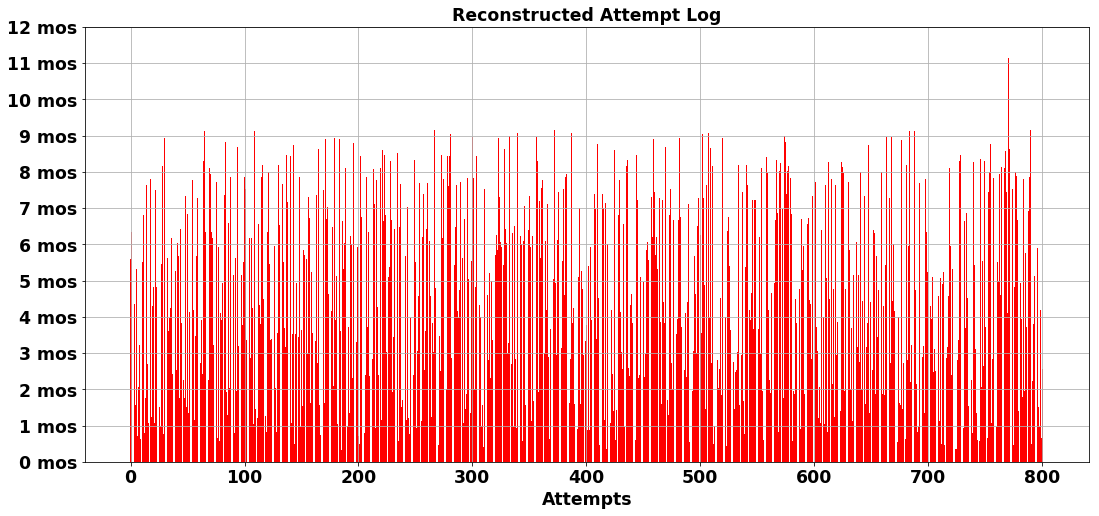

In [3]:
#Plot attempts as bar graph
kwargs = {'fontsize': 'xx-large',
          'fontweight': 'extra bold'}
#Set y ticks to resemble the ones in the screenshot
yticks = np.arange(0, 390, 30)
ylabels = [str(x) + ' mos' for x in np.arange(0, 13, 1)]
#Draw figure
fig = plt.figure(figsize = (18,8))
#Draw a grid like in the screenshot
plt.grid()
#Draw a bar graph like in the screenshot
plt.bar(range(pop_size), attempts, color = 'red')
plt.xlabel('Attempts', **kwargs)
plt.xticks(**kwargs)
plt.yticks(yticks, ylabels, **kwargs)
plt.title('Reconstructed Attempt Log', **kwargs)
plt.show()

![attemptlogsmall.png](https://raw.githubusercontent.com/ssrosa/the_soulmate_statistic/master/attemptlogsmall.png)

Not bad! With this distribution we can now run statistical tests.

### Hypothesis test: one-sample t test with one tail

s01e12, 'Mindy St. Claire':

(562, Michael: 'I think that we can get them to torture each other for 1,000 years.')
(563, Sean: 'I think you'll be lucky to get six months out of this insane gambit.')

Michael's guess is too far off to be worth testing. Sean's is much closer to the observed mean of the distribution. 'I think you'll be lucky to get six months out of this insane gambit' is like saying 'I predict you will get less than six months.'

"You will get six months or more"
 
**Null hypothesis: mu ≥ 6 months**

"You will get less than six months"

**Alternative hypothesis: mu < 6 months**

In [4]:
alpha = 0.05
seans_mean = (31 * 3) + (30 * 2) + 28 #181 days

#Test Sean's mean using Scipy's one-sample t test
test_statistic, pvalue = stats.ttest_1samp(attempts, seans_mean)
print('Test statistic:', test_statistic)
print('P value:', pvalue)
print('Sean\'s mean:', seans_mean, 'days')
print('Sample mean:', attempts.mean(), 'days')
print('P less than alpha?', alpha > pvalue)

Test statistic: -14.840414347674871
P value: 3.3935199674803e-44
Sean's mean: 181 days
Sample mean: 140.06234413965086 days
P less than alpha? True


### Results

Sean's guess was right. The p value is less than the alpha so we reject the null hypothesis that the neighborhood can last as long as or longer than 6 months.

It may not be intuitive that Sean's mean is far enough away from the observed mean to be significant. We can see this more clearly in a histogram of the attempts distribution. The tails on a normal distribution would be easier to see than the tails on our attempts distribution. We can take advantage of the Central Limit Theorem to resample the distribution into a new set that looks more 'normal'. 

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


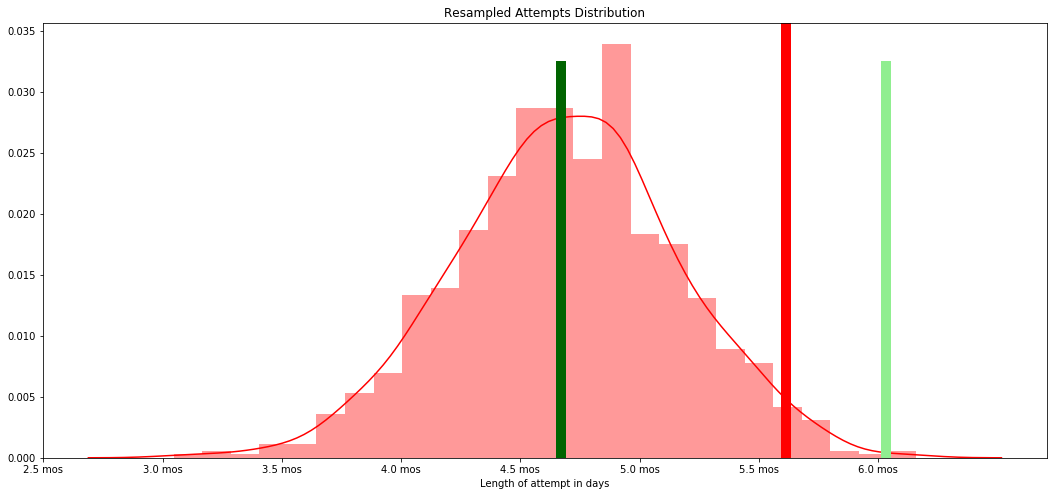

In [5]:
#Build a new distribution using a 1000 means of random samples of size 30 from attempts.
sampled_attempts = [np.random.choice(attempts, size = 30, \
                        replace = True).mean() for i in range(1000)]

#The upper bound marks the highest possible that an event in the distribution 
#can have without being statistically significant.
upper_bound = np.percentile(sampled_attempts, 97.5)

#Mark the x axix from 2 months to 7 months
xticks = np.arange(75, 195, 15)
xlabels = [str(x) + ' mos' for x in np.arange(2.5, 7, .5)]

fig = plt.figure(figsize = (18,8))
sns.distplot(sampled_attempts, color = 'red')
kwargs = {'c': 'darkgreen',
          'label': 'average length',
          'linewidth': 10
        }
plt.axvline(x = attempts.mean(), ymax = 0.9, **kwargs)

kwargs = {'c': 'red',
          'label': 'alpha',
          'linewidth': 10
        }
plt.axvline(x = upper_bound, ymax = 1, **kwargs)

kwargs = {'c': 'lightgreen',
          'label': 'Sean\'s prediction',
          'linewidth': 10
        }
plt.axvline(x = seans_mean, ymax = 0.9, **kwargs)

plt.xticks(xticks, xlabels)
plt.xlabel('Length of attempt in days')
plt.title('Resampled Attempts Distribution')
plt.legend()
plt.show()

In this distribution we can see just how far away Sean's guess is from the observed. It's way outside the range of values that would not be statistically significant.

Sean's guess was right. It would be better to torture humans the old-fashioned way, e.g.:

In [ ]:
#I was just torturing William Shakespeare...
shakespeare = ['Entourage']
shakespeare_lines = find_lines(shakespeare, scripts)
print_lines(titles, shakespeare_lines)

Michael is frustrated that his experiment didn't go the way he wanted.

In [ ]:
#Saddest moment
saddest = ['saddest']
saddest_lines = find_lines(saddest, scripts)
print_lines(titles, saddest_lines)

The main insight taken from this experiment is that people are apparently good. It is such a paradigm shift for Michael that it takes him most of the second season to understand.

In [ ]:
#people good people good
people_good = ['People good']
people_good_lines = find_lines(people_good, scripts)
print_lines(titles, people_good_lines)

# Chidi and Eleanor fall in love

The weirdest insight to arise from Michael's experiment was that two humans who were hand-selected to torture each other could turn out to be soulmates. They only fell in love once, but I was interested to explore what this rare event meant probabilistically.

In [ ]:
falling = ['have feelings for', 'I love you', 'I think I love you', 'mates']
falling_lines = find_lines(falling, scripts)
print_lines(titles, falling_lines)

s02e04, Team Cockroach'

Eleanor: 'How many times in all the reboots did I ask Chidi for help, he refused to help me and then I had to get better on my own?'
Michael: 'Never. He always helped you.'
Eleanor: 'God. Really?'
Michael: ' Yep. No matter how I set it up, you found him, confessed you didn't belong, asked him for help, and he said yes. Now his agreeing to help was part of my plan. What wasn't part of my plan was it actually working. Drove me nuts. Pesky little nerd.')

s03e07, A Fractured Inheritance

 (337,
  ' In one of the reboots, you and Chidi fell in love deeply, and you told him that you loved him, and he told you that he loved you back.')#Mihael tells Eleanor about falling in love with Chidi in reboot 119

s03e08, The Worst Possible Use of Free Will

Michael: 'So now I can show you the highlights of reboot 119.'
Eleanor: 'Oh, yeah? We know this is, like, the hundredth time you've tried to torture us, but this time it's different, because we're in love. And love is stronger than anything you can throw at us. No matter what he does, we will find each other, and we will help each other, because we're soul mates.'
Michael: 'I put you and Chidi in close proximity, because I needed you to drive each other crazy. But I never intended for you to fall in love.'

### Reconstructing a probability distribution

All we really know is that they fell in love once out of 801 attempts. Visualizing it gives us a sense of the rarity of the event.

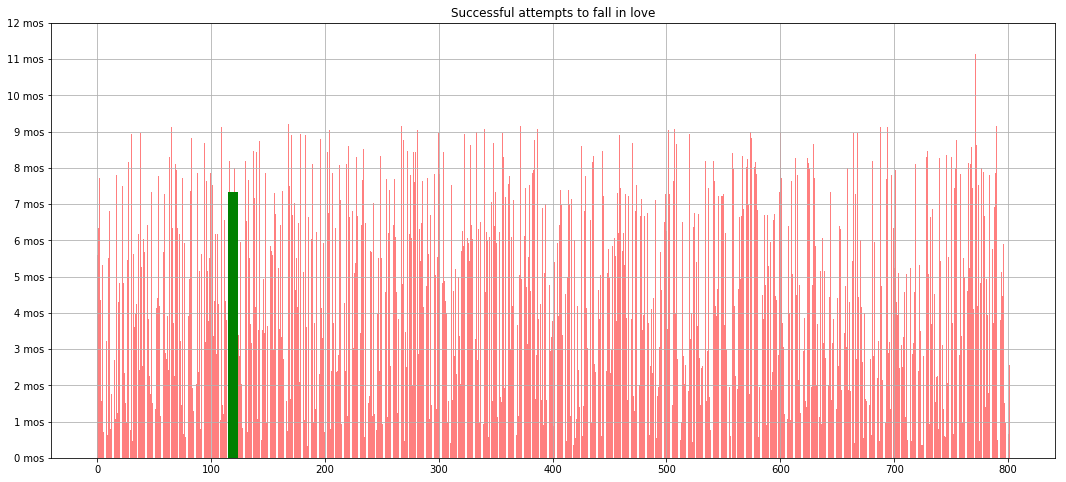

In [6]:
#Plot attempts with one success at being soulmates
fig = plt.figure(figsize = (18,8))
plt.grid()
kwargs = {'alpha': 0.5}
plt.bar(range(pop_size), attempts, color = 'red', **kwargs)
#Attempt 119 (soulmates) in green
kwargs = {'color': 'green',
          'label': 'soulmates',
          'linewidth': 10
        }
plt.axvline(x = 119, ymax = 0.6, **kwargs)
plt.yticks(yticks, ylabels)
plt.title('Successful attempts to fall in love')
plt.show()

(A real probability distribution for this event would be difficult to interpret.)

We don't know the probability of success in one trial, but we can get some perspective on it by looking at a couple guesses. We'll see what it looks like for a soulmate statistic of 1/81, 1/801, and 1/8001 when you have 801 trials.

In [8]:
n = 801 #Number of trials 
k = np.arange(n) #X axis for the plot

p81 = (1/81)
binom81 = stats.binom.pmf(k, n, p81)
sim81 = stats.binom.rvs(n, p81, size = 801)
c81 = 'orange'

p801 = (1/801)
binom801 = stats.binom.pmf(k, n, p801)
sim801 = stats.binom.rvs(n, p801, size = 801)
c801 = 'red'

p8001 = (1/8001)
binom8001 = stats.binom.pmf(k, n, p8001)
sim8001 = stats.binom.rvs(n, p8001, size = 801)
c8001 = 'gray'

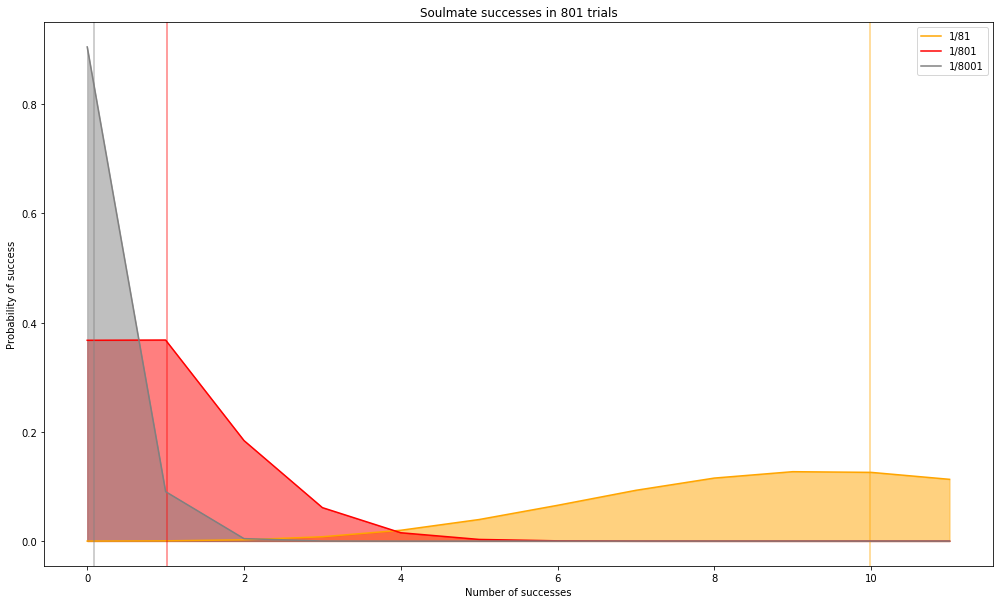

In [25]:
#Showing all 801 trials would make the plot hard
#to read, so we'll only see 12 trials.
xmax = 12
x = np.arange(xmax)

#Draw figure
fig = plt.figure(figsize = (17,10))

#Plot soulmate statistic as 1/81
plt.plot(x, binom81[:xmax], color = c81, label = '1/81')
kwargs = {'color': c81, 'alpha': 0.5}
plt.axvline(sim81.mean(), **kwargs)
plt.fill_between(x, 0, binom81[:xmax], **kwargs)

#Plot soulmate statistic as 1/801
plt.plot(x, binom801[:xmax], color = c801, label = '1/801')
kwargs = {'color': c801, 'alpha': 0.5}
plt.axvline(sim801.mean(), **kwargs)
plt.fill_between(x, 0, binom801[:xmax], **kwargs)

#Plot soulmate statistic as 1/8001
plt.plot(x, binom8001[:xmax], color = c8001, label = '1/8001')
kwargs = {'color': c8001, 'alpha': 0.5}
plt.axvline(sim8001.mean(), **kwargs)
plt.fill_between(x, 0, binom8001[:xmax], **kwargs)

#Labels
plt.xlabel('Number of successes')
plt.ylabel('Probability of success')
plt.legend()
plt.title('Soulmate successes in 801 trials')
#Draw plot
plt.show()

The plot shows that our 1 observed success in 801 trials would be very unlikely with a soulmate statistic of 1/81 and 1/8001. (Unlucky in the former, lucky in the latter.)

In [ ]:
#That wasn't me who fell in love with you.
wasnt = ['Wikipedia']
wasnt_lines = find_lines(wasnt, scripts)
print_lines(titles, wasnt_lines)

season 3 episode 10

 (147, ' Conceptions of the self.'),
 (148,
  " Let's start with John Locke, who believed that personal identity was based on having a continued consciousness essentially, memory."),
 (149, ' Memories are links in a chain that together form a single self.'),
 (150,
  " If I can't remember what happened because it happened to a Chidi from another timeline, it's not a unified me."),
 (151,
  " Just because you don't remember doing something doesn't mean you didn't do it."),
 (152,
  ' I have no idea how it happened, but there is definitely a tattoo on my butt that says "Jasom.'),
 (153, '" That leads us to Derek Parfit.'),
 (154,
  " - It does? - Parfit said even if I have memories from an earlier time, that doesn't necessarily mean it was me."),
 (155,
  " After all, if my brain was split in two and each half was put in a different person, which one is me? All I know is that other Chidi doesn't exist anymore, and this one does."),
 (156, ' So this must be the real Chidi.')
 
### So are they in love now or not?

Eleanor discounts the rarity of the falling-in-love event by insisting that she and Chidi are soulmates. It's a big leap for Chidi to accept that something he did in an unremembered earlier life can impact his current life.

# The perfect system

One conclusion to be drawn from the show is that we should be careful not to over-trust and over-apply our data. Our systems are not perfect. The immortals running the Good and Bad Places trust their system too much. It is mentioned over and over.

In [ ]:
the_system = ['system']
system_lines = find_lines(the_system, scripts)
print_lines(titles, system_lines)

s01e01, Everything Is Fine

(64, ' [laughter] Anyway, when your time on Earth has ended, we calculate the total value of your life using our perfectly accurate measuring system.')
(83, " Again, it's an incredibly selective system.")
(370, " See, that's the trouble with these perfect systems.")

s01e08, Most Improved Player

(4, " Our system has never made a mistake before It's just not possible.")


s02e01, Everything is Great!

(180, " Now, normally, our omniscient system perfectly analyzes each person's profile, and then matches him or her with another person.")

s03e010, Janet(s)

(136, ' [whooshing] The system is flawless, and tampering is quite impossible.')

# The Time-Knife

In my article I imagine different kinds of infinity. I got the idea from the Time-Knife.

In [ ]:
#Time-Kinfe
timeknife = ['Time-Knife']
timeknife_lines = find_lines(timeknife, scripts)
print_lines(titles, timeknife_lines)

# Boat on a lake

The closing image in my article is of Eleanor and Chidi in a boat on a lake. I found this significant because it was so different from the boat on the lake was first brought up.

In [ ]:
#Boat on a lake, red wine, French poetry
redwine = ['poetry']
redwine_lines = find_lines(redwine, scripts)
print_lines(titles, redwine_lines)

# Future work: Janet

I didn't get to use this for my article on soulmates but it interesting to think about. Could be good for another article. Who or what is Janet, really?

In [ ]:
janet = ['janet', 'robot', 'know everything about', 'knowledge', 'updat', 'database']
janet_lines = find_lines(janet, scripts)
print_lines(titles, janet_lines)

s01e01, Everything Is Fine

(161, " She's like this walking database.")

s01e07, The Eternal Shriek

(181, ' Each new update of Janet gains more wisdom and social abilities.')
(207, ' I am simply an anthropomorphized vessel of knowledge built to make your life easier.')
(272, " Uh, her memory must have been wiped clean, so now she's gonna have to re-upload all the knowledge in the universe, which will only take a few days.")

s01e09
(146, " I mean, it does matter if I know things, because I'm an informational delivery system, and I don't have a heart, but thanks.")

s01e10, Chidi's Choice

(288, '" - [gags] - "Jacksonville Jaguars rule!" Jason, when I was rebooted, and I lost all my knowledge, I was confused and disoriented, but you were always kind to me.')

s01e11, What's My Motivation

(113, ' As you know, each time I am updated, I accrue new knowledge and abilities.')

s02e06, The Trolley Problem

(75, ' I am simply a vessel containing all of the knowledge in the universe.')

s02e07, Janet and Michael

(191, ' Say what now? After the very first time you were rebooted, and as you were slowly regaining your knowledge, you bonded with Jason.')

(358, " You contain all the knowledge in the universe, you have a rippin' bod, and you can literally do anything.")

s02e10, Best Self

(138, ' In case you were wondering, I am by definition the best version of myself, because my operating system is always updating.')

s02e12, The Burrito

(47, " Wait, you don't already know everything about us? You're not omniscient? Well Not in the way you mean.")

s03e03, The Brainy Bunch

(127, ' Ever since we walked through that portal, my knowledge has stopped updating.')

s03e06, The Ballad of Donkey Doug

(29, ' I do know everything about you and Simone and computer programming and virtual reality and artificial intelligence and the human brain and everything else.')

s03e13, Pandemonium

(43, ' Janet is a walking database of all the knowledge in the universe, and since you, John, seem to like asking a relentless number of questions, go ahead.')

# Future work: the points system

If you'd like to investigate the point system, and maybe figure out how many points it takes to get into the Good Place, you can use this code. I couldn't figure it out based on the dialogue available in seasons 1 through 3.

In [ ]:
points = [' points', ' earn', ' lose', 'lost', 'losing']
points_lines = find_lines(points, number_lines)
print_lines(titles, points_lines)

s01e11, What's My Motivation

(9, ' Now, the average point total for a resident here is roughly 1.2 million.')
 
s3e10, Janet(s)
 
 (165,
  " Can you just tell me his total so far? Looks like he's at 520,000 points."),
 (166, ' - Well done, Doug.'),
 (167, " - So that's that's good? Oh, it's excellent."),
 (168, " Wait, he's 68 years old? Oh, that's terrible."),
 (169, " He's screwed."),